# DataSet #2: Mobilitat entre Municipis

Autor: Marc Bosch Manzano<br>
Data: Octubre 2025<br>
Iteració: 2a<br>
Projecte: MobiCat

Assignació: Christopher, Marc

## Anàlisi de Mapes de Municipis

### Importació de Llibreries

In [ ]:
PACKAGES = ["pandas", "geopandas", "numpy", "seaborn", "matplotlib"]
COLORS = ["viridis", "plasma", "inferno", "magma", "cividis"]

import importlib
import os
import sys
sys.path.append('../mobicat_python_utils')

import utils 
utils.install_missing_packages(PACKAGES)
importlib.reload(utils)

import os
import seaborn as sns
import numpy as np
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt

import IPython.display 
IPython.display.clear_output()

### Importació de Dades

**Important**: copia al directori *test-data* els següents fitxers, o introduir el directori correcte amb els fitxers. 
```bash
    movilidad_barrios_2023-01_origen.csv
    movilidad_municipios_2023-01_origen.csv
    movilidad_mun_barrios_2023-01_origen.csv
```

Importem el dataframe de mobilitat de municipis en d'un mes. Les descripcions de les dades de mobilitat de Telefónica estan al PDF [Metadata Mobile Data Challenge DataSets 2025.pdf](./test-data/Metadata%20Mobile%20Data%20Challenge%20DataSets%202025.pdf). Li apliquem un filtre d'escollir els viatges majors a 0.

In [ ]:
mobility_directory = "./test-data/"
mobility_file_name = "movilidad_municipios_2023-01_origen.csv"
mobility_file_path = os.path.join(mobility_directory, mobility_file_name)

mobility_df = pd.read_csv(mobility_file_path, dtype=str)
mobility_df["viajes"] = mobility_df["viajes"].astype(int)
mobility_df["day"] = pd.to_datetime(mobility_df["day"])
mobility_df = mobility_df[mobility_df["viajes"] > 0]

In [48]:
display(mobility_df.sample(5))
print(mobility_df.shape)

,day,day_of_week,month,origen,municipio_origen,municipio_origen_name,municipio_destino,municipio_destino_name,viajes
754356,2023-01-12,Jueves,01,Regional,08305,Vilafranca del Penedès,08302,Vilanova del Camí,78
1553796,2023-01-26,Jueves,01,Internacional,08019,Barcelona,08056,Castelldefels,1105
990326,2023-01-16,Lunes,01,Regional,08267,Sentmenat,08209,Sant Fost de Campsentelles,26
1879207,2023-01-31,Martes,01,Regional,08101,"Hospitalet de Llobregat, L'",08135,Montmeló,22
331689,2023-01-06,Viernes,01,Nacional,08054,Castellbisbal,08196,Sant Andreu de la Barca,40


(508839, 9)


Importem el dataframe de les cartografies dels límits administratius dels municipis de l'ICGC. Les descripcions d'aquestes dades estan al següent PDF [divisions-administratives-v2r1-20250207.pdf](../catalonia-geography-maps/icgc/divisions-administratives-v2r1-20250207.pdf).

In [27]:
map_directory = "../catalonia-geography-maps/icgc/divisions-administratives-v2r1-20250730/"
map_file_name = "divisions-administratives-v2r1-municipis-5000-20250730.shp" 
map_file_path = os.path.join(map_directory, map_file_name)

map_df = gpd.read_file(map_file_path)

Apliquem les següents transformacions a les dades de cartografia:
1. Ens quedem només amb els pobles de la província de Barcelona.
2. Ens quedem només amb els atributs del codi del municipi, el, nom i la geometria.
3. Afegim una nova columna amb els codis dels municipis en els codi de l'Institut Nacional d'Estadística (INE): són els cinc primers dígits dels codis de la Generalitat de Catalunya.

In [45]:
map_filtered_df = map_df[map_df["NOMPROV"] == "Barcelona"]
map_filtered_df = map_filtered_df[["CODIMUNI", "NOMMUNI", "geometry"]]
map_filtered_df["CODIMUNI_INE"] = map_filtered_df["CODIMUNI"].apply(lambda s: s[0:5])
map_filtered_df["CODIMUNI_IDESCAT"] = map_filtered_df["CODIMUNI"]
map_filtered_df = map_filtered_df.drop(columns="CODIMUNI")

In [47]:
display(map_filtered_df.sample(5))
print(map_filtered_df.shape)

,NOMMUNI,geometry,CODIMUNI_INE,CODIMUNI_IDESCAT
188,Sallent,"POLYGON ((413999.4 4639751, 413984.6 4639464.2...",08191,081918
245,Santa Eulàlia de Ronçana,"POLYGON ((433822.303 4613094.39, 433829.336 46...",08248,082482
231,Sant Pere de Vilamajor,"POLYGON ((448052.702 4623353.579, 448061.106 4...",08234,082346
227,Premià de Dalt,"POLYGON ((444410.619 4597266.995, 444418.69 45...",08230,082303
60,Castellgalí,"POLYGON ((402748.4 4616337.9, 403098.8 4616370...",08061,080615


(311, 4)


Ara la nostra idea seria encreuar dades cartogràfiques amb dades de mobilitat per cada municipi. 

Apliquem un agrupament dels municipis pel nombre de viatges. D'aquesta forma reduïm la complexitat del join i ens podrem veure els municipis amb més nombre de viatges.

In [66]:
origin_grouped_df = mobility_df.groupby(by="municipio_origen", as_index=False)["viajes"].sum()
origin_grouped_df = origin_grouped_df.rename(columns={"viajes": "viajes_origen"})
display(origin_grouped_df.sort_values(by="viajes_origen", ascending=False).head(5))
print(origin_grouped_df.shape)

destiny_grouped_df = mobility_df.groupby(by="municipio_destino", as_index=False)["viajes"].sum()
destiny_grouped_df = destiny_grouped_df.rename(columns={"viajes": "viajes_destino"})
display(destiny_grouped_df.sort_values(by="viajes_destino", ascending=False).head(5))
print(destiny_grouped_df.shape)

,municipio_origen,viajes_origen
18,08019,21038046
98,08101,5366782
180,08187,3507736
14,08015,3486870
165,08169,3038235


(303, 2)


,municipio_destino,viajes_destino
18,08019,20839931
98,08101,5396419
14,08015,3527771
180,08187,3509980
165,08169,3051339


(303, 2)


Encreuem les dades de cartografies i municipis d'origen i destí.

In [ ]:
origin_map_df = map_filtered_df.join(
    other=origin_grouped_df\
        .rename(columns={"municipio_origen": "CODIMUNI_INE"})\
        .set_index("CODIMUNI_INE"),
    on="CODIMUNI_INE",
    how="left"
)

mobility_map_df = origin_map_df.join(
    other=destiny_grouped_df\
        .rename(columns={"municipio_destino": "CODIMUNI_INE"})\
        .set_index("CODIMUNI_INE"),
    on="CODIMUNI_INE",
    how="left"
)

mobility_map_df = gpd.GeoDataFrame(mobility_map_df)

Imputem valors nuls a les columnes dels recomptes de viatges com els valors mínims d'aquestes columnes.

In [112]:
mobility_map_df["viajes_origen"] = mobility_map_df["viajes_origen"].fillna(mobility_map_df["viajes_origen"].min())
mobility_map_df["viajes_destino"] = mobility_map_df["viajes_destino"].fillna(mobility_map_df["viajes_destino"].min())

Mostrem les dades dels viatges d'origen i de destí.

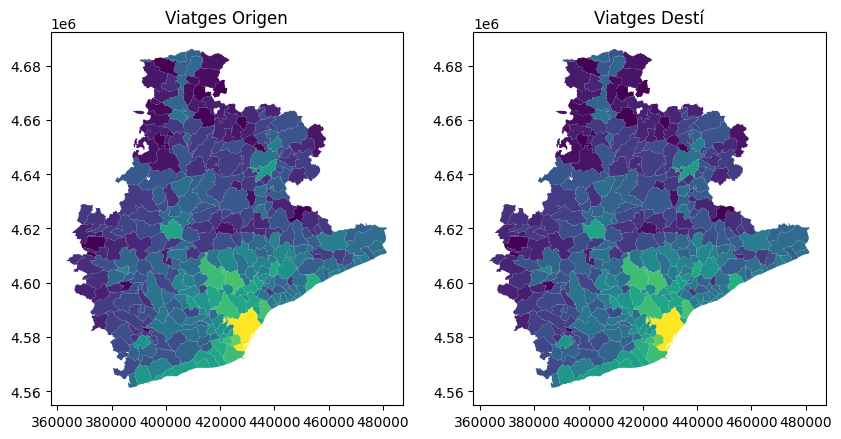

In [162]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].set_title("Viatges Origen")
_ = mobility_map_df.plot(
    column=np.log(mobility_map_df["viajes_origen"]) ** 3, 
    ax=ax[0]
)

ax[1].set_title("Viatges Destí")
_ = mobility_map_df.plot(
    column=np.log(mobility_map_df["viajes_destino"]) ** 3, 
    ax=ax[1]
)
plt.show()

Mostrem la diferència entre viatges d'origen i destí.

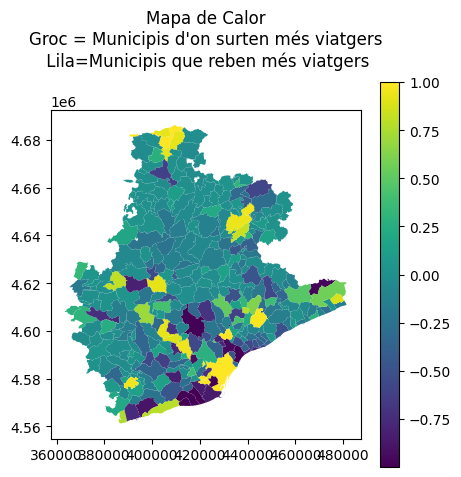

In [178]:
mobility_map_df["viajes_diff"] = mobility_map_df["viajes_origen"] - mobility_map_df["viajes_destino"]

fig, ax = plt.subplots(figsize=(5, 5))
_ = mobility_map_df.plot(
    column=np.tanh(mobility_map_df["viajes_diff"] / 10000), 
    ax=ax,
    legend=True,
    cmap="viridis"
)
plt.title("Mapa de Calor\nGroc = Municipis d'on surten més viatgers\n Lila=Municipis que reben més viatgers\n")
plt.show()

Possibles idees: encreuar dades de poblacions d'IDESCAT. Fer més mapes.